# **Solve Laplace problem using Deep Learning and CNN's**

In this notebook we use a convolutional neural network (CNN) to solve the Laplace equation using a boundary condition as input. 

**If using Google Colab, run this:**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import csv
import time

# Import data

Here we import the data. The data conists of linear standing waves. The training data, validation data and test data are all within one period of the wave. The training data consists of 100 time steps, the validation data of 250 time steps and the test data of 1000 time steps. \\
We note that the data consists of both the velocity potential, $P$, the horizontal velocity, $U$ and the vertical velocity, $W$. The naming convention will be used troughout the notebook. \\
We have also included unseen data. That is data, which with an arbitrary surface. This data set is used to test the generalation ability of the networks. 

In [13]:
Nx = 11
Ny = 11
Nsteps_train = 100
Nsteps_val = 250
Nsteps_test = 1000
Nsteps_uns = 100

data_train = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_Nx11Nz11Nt100_Train.csv', delimiter=',').reshape((Nsteps_train,3*Nx*Ny),order='A').astype('float32')
data_val = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_Nx11Nz11Nt250_Val.csv', delimiter=',').reshape((Nsteps_val,3*Nx*Ny),order='A').astype('float32')
data_test = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_Nx11Nz11Nt1000_Test.csv', delimiter=',').reshape((Nsteps_test,3*Nx*Ny),order='A').astype('float32')
data_unseen = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/DATA_ARB_Nx11Nz11Nt100_test.csv', delimiter=',').reshape((Nsteps_uns,3*Nx*Ny),order='A').astype('float32')
grid = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/Grid_Nx11Nz11Nt100_Train.csv', delimiter=',').reshape((Nx*Ny,3)).astype('float32')
data_elev = np.genfromtxt('/content/drive/My Drive/Data Deep Learning Project/E_Nx11Nz11Nt1000_Test.csv', delimiter=',').reshape((Nsteps_test,Nx),order='A').astype('float32')
x = grid[:,0]
X = x.reshape((Nx,Ny),order='F')
xx = X[0,:]
z = grid[:,1]
Z = z.reshape((Nx,Ny),order='F')
zz = Z[:,0]
s = grid[:,2]
S = s.reshape((Nx,Ny),order='F')
ss = S[:,0]

np.random.shuffle(data_train)

# Different domain indices
idx_2D = np.arange(0,3*Nx*Ny)
idx_surface = np.linspace(0,Nx*Ny,12).astype(int)
idx_surface = idx_surface[:-1]
idx_domain = np.setxor1d(idx_2D, idx_surface)
P_idx = range(0,Nx*Ny)
U_idx = range(Nx*Ny,2*Nx*Ny)
W_idx = range(2*Nx*Ny,3*Nx*Ny)

# Collect into inputs (X) and outputs (Y)
X_train = data_train[:,idx_surface]
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
Y_train = data_train
X_val = data_val[:,idx_surface]
X_val = X_val.reshape((X_val.shape[0],X_val.shape[1],1))
Y_val = data_val
X_test = data_test[:,idx_surface]
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
Y_test = data_test
X_uns = data_unseen[:,idx_surface]
X_uns = X_uns.reshape((X_uns.shape[0],X_uns.shape[1],1))
Y_uns = data_unseen

# Print data shapes
print('x-grid shape: ',xx.shape)
print('\nTraining data:')
print('Input shape : ',X_train.shape)
print('Output shape: ',Y_train.shape)
print('\nValidation data:')
print('Input shape : ',X_val.shape)
print('Output shape: ',Y_val.shape)
print('\nTest data:')
print('Input shape : ',X_test.shape)
print('Output shape: ',Y_test.shape)
print('\nUnseen data:')
print('Input shape : ',X_uns.shape)
print('Output shape: ',Y_uns.shape)


x-grid shape:  (11,)

Training data:
Input shape :  (100, 11, 1)
Output shape:  (100, 363)

Validation data:
Input shape :  (250, 11, 1)
Output shape:  (250, 363)

Test data:
Input shape :  (1000, 11, 1)
Output shape:  (1000, 363)

Unseen data:
Input shape :  (100, 11, 1)
Output shape:  (100, 363)


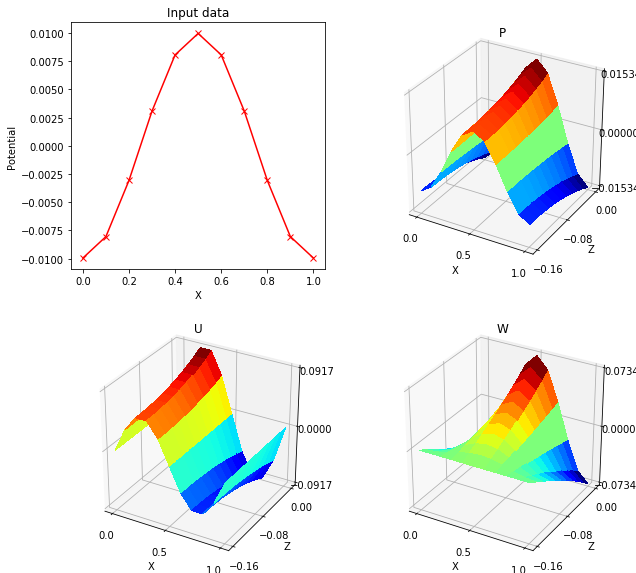

In [16]:
plot_idx=10
# Example of input (potential at surface)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
plt.plot(xx,X_train[plot_idx,:],'r-x')
ax.set_xlabel('X')
ax.set_ylabel('Potential')
ax.set_title('Input data')


# Example of corresponding output: Potential (entire domain)
#fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(2, 2, 2, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_train[plot_idx,P_idx]), 0, np.max(Y_train[plot_idx,P_idx])])
ax.set_title('P')
ax.plot_surface(X, Z, Y_train[plot_idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding horisontal velocity (entire domain)
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_train[plot_idx,U_idx]), 0, np.max(Y_train[plot_idx,U_idx])])
ax.set_title('U')
ax.plot_surface(X, Z, Y_train[plot_idx,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding vertical velocity (entire domain)
ax = fig.add_subplot(2, 2, 4, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_train[plot_idx,W_idx]), 0, np.max(Y_train[plot_idx,W_idx])])
ax.set_title('W')
ax.plot_surface(X, Z, Y_train[plot_idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

# Define Model

Next we will define our CNN model. It consitst of a 1D-convolution, a 2D-convolution and a fully connected layer. We have used zero-padding to retain the sizes troughout the network.  \\

Last we remark that no work on reducing overfitting has been done since the data are analytic solutions. 

In [0]:
class CNN(nn.Module):
  def __init__(self,input_size,upsampling_size,no_channels_2D,output_size):
      super(CNN,self).__init__()

      # Conv1d
      self.conv_1d = nn.Conv1d(in_channels=1,
                            out_channels=upsampling_size,
                            kernel_size=3,
                            stride=1,
                            padding=1,
                            padding_mode='zeros')

      # Conv2d
      self.conv_2d = nn.Conv2d(in_channels=1,
                            out_channels=no_channels_2D,
                            kernel_size=5,
                            stride=1,
                            padding=2,
                            padding_mode='zeros')
      
      # Compute number of features
      num_features = no_channels_2D * upsampling_size * Nx 

      # FFNN
      self.FFNN = nn.Linear(in_features=num_features,
                            out_features=output_size,
                            bias=False)
  
  def forward(self,x):
      # From 1D to 2D
      x = self.conv_1d(x)

      # 2D convolution
      x = x.reshape((x.shape[0],1,no_filters_1d,Nx))
      x = self.conv_2d(x)

      # FFNN
      x = x.view(x.shape[0],-1)
      x = self.FFNN(x)
      return x


In [32]:
# Test forward pass
Batch_size = 100
no_filters_1d = Nx;
no_filters_2d = 5
output_size = 3*Nx*Ny
CNN_net = CNN(Nx,no_filters_1d,no_filters_2d,output_size)
print(CNN_net)

input_test = np.random.normal(0, 1, (Batch_size, 1,Nx)).astype('float32')
output_test = CNN_net(Variable(torch.from_numpy(input_test)))
print('Expected output size:   [%i, %i]' %(Batch_size,output_size))
print('Output size from model: [%i, %i]' %(output_test.shape[0],output_test.shape[1]))


CNN(
  (conv_1d): Conv1d(1, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv_2d): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (FFNN): Linear(in_features=605, out_features=363, bias=False)
)
Expected output size:   [100, 363]
Output size from model: [100, 363]


In [25]:
pytorch_total_params = sum(p.numel() for p in CNN_net.parameters() if p.requires_grad)
print('Number of parameters in CNN:',pytorch_total_params)

Number of parameters in CNN: 219789


## Train Model

Here we train our network. We use the simple mean-squared-error loss function. We train for 1000 epochs.

In [26]:
# Set up loss, optimizer and then network

def MSE_loss_func(output,target):
  MSE_loss = torch.mean((output-target)**2)
  return MSE_loss

CNN_S = CNN(Nx,no_filters_1d,no_filters_2d,output_size)
print(CNN_S)

optimizer = optim.Adam(CNN_S.parameters(), lr=1e-3)

CNN(
  (conv_1d): Conv1d(1, 11, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv_2d): Conv2d(1, 5, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (FFNN): Linear(in_features=605, out_features=363, bias=False)
)


Epoch:   0, Train loss: 0.013865, Inf norm: 0.358931, Val loss: 0.005574, Val norm: 0.257701
Epoch: 100, Train loss: 0.000769, Inf norm: 0.120677, Val loss: 0.000748, Val norm: 0.119423
Epoch: 200, Train loss: 0.000003, Inf norm: 0.017891, Val loss: 0.000003, Val norm: 0.017528
Epoch: 300, Train loss: 0.000000, Inf norm: 0.002257, Val loss: 0.000000, Val norm: 0.002214
Epoch: 400, Train loss: 0.000000, Inf norm: 0.000264, Val loss: 0.000000, Val norm: 0.000258
Epoch: 500, Train loss: 0.000000, Inf norm: 0.000020, Val loss: 0.000000, Val norm: 0.000019
Epoch: 600, Train loss: 0.000000, Inf norm: 0.000008, Val loss: 0.000000, Val norm: 0.000008
Epoch: 700, Train loss: 0.000000, Inf norm: 0.000008, Val loss: 0.000000, Val norm: 0.000008
Epoch: 800, Train loss: 0.000000, Inf norm: 0.000008, Val loss: 0.000000, Val norm: 0.000008
Epoch: 900, Train loss: 0.000000, Inf norm: 0.000008, Val loss: 0.000000, Val norm: 0.000008


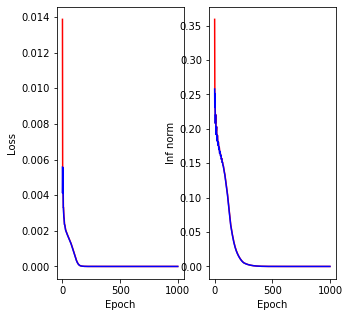

In [27]:
# Train network
num_epochs = 1000

# setting up lists for handling loss/accuracy
train_norm, train_loss = [], []
val_norm, val_loss = [], []
loss = 0
timing = []

for epoch in range(num_epochs):
  start = time.time()
  # Training
  CNN_S.train()
  output = CNN_S(Variable(torch.from_numpy(X_train).reshape(Nsteps_train,1,Nx)))
  target = Variable(torch.from_numpy(Y_train))
  loss = MSE_loss_func(output,target)
  train_norm.append(torch.max(torch.abs(output-target)))
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  train_loss.append(loss)
  timing.append(time.time()-start)
  # Evaluation
  CNN_S.eval()
  target_val = CNN_S(Variable(torch.from_numpy(X_val).reshape(Nsteps_val,1,Nx)))
  output_val = Variable(torch.from_numpy(Y_val))
  val_loss.append(MSE_loss_func(output_val,target_val))
  val_norm.append(torch.max(torch.abs(output_val - target_val)))
  if epoch % (num_epochs/10) == 0:
    print('Epoch: %3i, Train loss: %f, Inf norm: %f, Val loss: %f, Val norm: %f' % (epoch,train_loss[-1], train_norm[-1],val_loss[-1], val_norm[-1]))

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.plot(range(num_epochs),train_loss,'r-')
plt.plot(range(num_epochs),val_loss,'b-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(range(num_epochs),train_norm,'r-')
plt.plot(range(num_epochs),val_norm,'b-')
plt.xlabel('Epoch')
plt.ylabel('Inf norm')
plt.show()

# Save to csv-files
#np.savetxt("/content/drive/My Drive/Results Deep Learning/train_loss_CNN_S_PUW.csv", train_loss, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/val_loss_CNN_S_PUW.csv", val_loss, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/train_norm_CNN_S_PUW.csv", train_norm, delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/val_norm_CNN_S_PUW.csv", val_norm, delimiter=",")




In [28]:
avr_time = sum(timing)/num_epochs
print('Total time for training %i epochs : %.2f s' % (num_epochs, sum(timing)))
print('Average timing per epoch            : %.4f s' % avr_time)

Total time for training 1000 epochs : 10.69 s
Average timing per epoch            : 0.0107 s


## Test Model

Next we test both models on the test data. We run every test set through the models, time the forward pass and also evaluate the error (the infinity norm). \\
We have at the end plotted a box plot of all the test errors and also the test results with the largest error. 

Maximum errors:
P:  1.2516975e-06
U:  8.739531e-06
W:  7.942319e-06
Interval of inf norms: (0.000000, 0.000009)


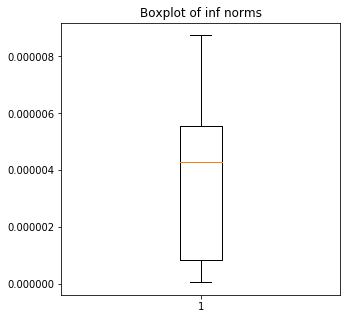

For test data #187 we observe the greatest error


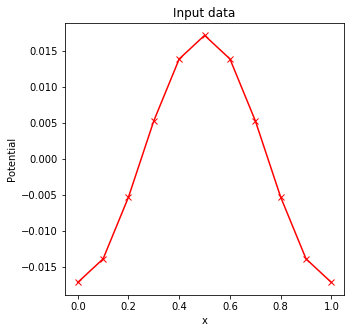

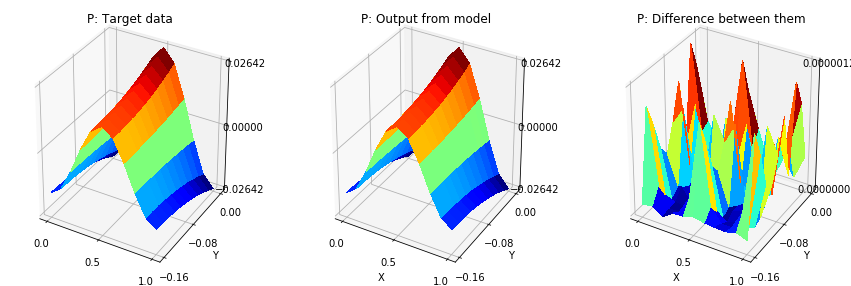

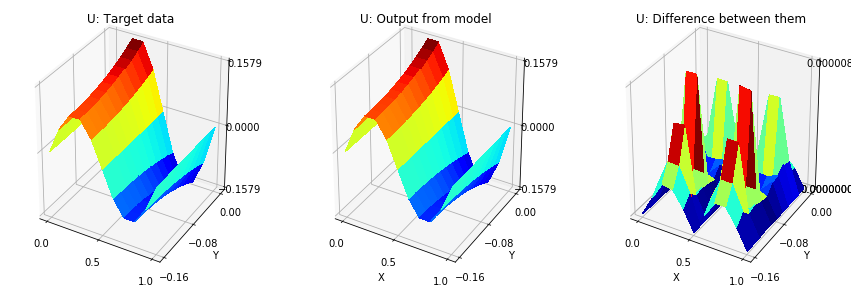

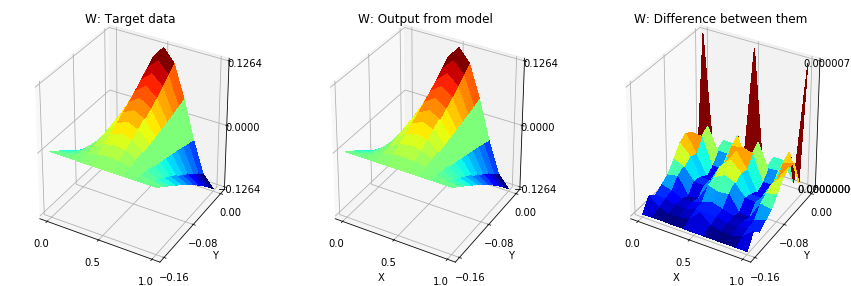

In [33]:
# Test network
test_loss, test_norm = [], []
outputs_from_test, error = [], []
timing_forward = []
CNN_S.eval()
for it in range(X_test.shape[0]):
  start = time.time()
  output_test = CNN_S(Variable(torch.from_numpy(X_test[it,:,:].reshape((1,1,Nx)))))
  timing_forward.append(time.time()-start)
  #print(output_test.shape)
  outputs_from_test.append(output_test.detach().numpy())
  target_test = Variable(torch.from_numpy(Y_test[it,:]).reshape((1,3*Nx*Ny)))
  loss_test = MSE_loss_func(output_test,target_test)
  test_loss.append(loss_test.detach().numpy())
  error.append(torch.abs((output_test-target_test)).detach().numpy())
  norm_test = torch.max(torch.abs(output_test-target_test))
  test_norm.append(norm_test.detach().numpy())

idx = np.argmax(test_norm)
max_error_P = []
max_error_U = []
max_error_W = []
for it in range(Nsteps_test):
  max_error_P.append(max(error[it][0][P_idx]))
  max_error_U.append(max(error[it][0][U_idx]))
  max_error_W.append(max(error[it][0][W_idx]))

print('Maximum errors:')
print('P: ',max(max_error_P))
print('U: ',max(max_error_U))
print('W: ',max(max_error_W))

# Save into csv-files
np.savetxt("/content/drive/My Drive/Results Deep Learning/X_test_CNNPUW.csv", X_test[idx,:], delimiter=",")
np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_test_P_CNNPUW.csv", Y_test[idx,P_idx], delimiter=",")
np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_test_U_CNNPUW.csv", Y_test[idx,U_idx], delimiter=",")
np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_test_W_CNNPUW.csv", Y_test[idx,W_idx], delimiter=",")
np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_output_P_CNNPUW.csv", outputs_from_test[idx][0][P_idx], delimiter=",")
np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_output_U_CNNPUW.csv", outputs_from_test[idx][0][U_idx], delimiter=",")
np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_output_W_CNNPUW.csv", outputs_from_test[idx][0][W_idx], delimiter=",")

#print('Test performance: Loss = %f, inf norm = %f' % (test_loss,test_norm))
print('Interval of inf norms: (%f, %f)' % (np.min(test_norm),np.max(test_norm)))
plt.figure(figsize=(5,5))
plt.boxplot(test_norm)
plt.title('Boxplot of inf norms')
plt.show()

print('For test data #%i we observe the greatest error' % (idx))

# Example of a test input 
fig = plt.figure(figsize=(5,5))
plt.plot(xx,X_test[idx,:],'r-x')
plt.xlabel('x')
plt.ylabel('Potential')
plt.title('Input data')
plt.show()

### PLOT P #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))
#fig_P, ax = plt.subplots(3) 

ax = fig.add_subplot(1, 3, 1, projection='3d')

##
#ax[0] = fig_P.gca(projection='3d')
#ax[0].set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_test[idx,P_idx]), 0, np.max(Y_test[idx,P_idx])])
ax.set_title('P: Target data')
ax.plot_surface(X, Z, Y_test[idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
#plt.show()

# Example of output from model 
#fig = plt.figure(figsize=(5,5))
#fig_P = plt.subplot(1,3,1) 
#ax = fig.gca(projection='3d')
#print(outputs_from_test[idx].shape)
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][P_idx]), 0, np.max(outputs_from_test[idx][0][P_idx])])
ax.set_title('P: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
#fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][P_idx]), 0, np.max(error[idx][0][P_idx])])
ax.set_title('P: Difference between them')
ax.plot_surface(X, Z, error[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

### PLOT U #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))
#fig_P, ax = plt.subplots(3) 

ax = fig.add_subplot(1, 3, 1, projection='3d')

##
#ax[0] = fig_P.gca(projection='3d')
#ax[0].set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_test[idx,U_idx]), 0, np.max(Y_test[idx,U_idx])])
ax.set_title('U: Target data')
ax.plot_surface(X, Z, Y_test[idx,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
#plt.show()

# Example of output from model 
#fig = plt.figure(figsize=(5,5))
#fig_P = plt.subplot(1,3,1) 
#ax = fig.gca(projection='3d')
#print(outputs_from_test[idx].shape)
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][U_idx]), 0, np.max(outputs_from_test[idx][0][U_idx])])
ax.set_title('U: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
#fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][U_idx]), 0, np.max(error[idx][0][U_idx])])
ax.set_title('U: Difference between them')
ax.plot_surface(X, Z, error[idx][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

#### PLOT W ####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))
#fig_P, ax = plt.subplots(3) 

ax = fig.add_subplot(1, 3, 1, projection='3d')

##
#ax[0] = fig_P.gca(projection='3d')
#ax[0].set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_test[idx,W_idx]), 0, np.max(Y_test[idx,W_idx])])
ax.set_title('W: Target data')
ax.plot_surface(X, Z, Y_test[idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
#plt.show()

# Example of output from model 
#fig = plt.figure(figsize=(5,5))
#fig_P = plt.subplot(1,3,1) 
#ax = fig.gca(projection='3d')
#print(outputs_from_test[idx].shape)
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][W_idx]), 0, np.max(outputs_from_test[idx][0][W_idx])])
ax.set_title('W: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
#fig = plt.figure(figsize=(5,5))
#ax = fig.gca(projection='3d')
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][W_idx]), 0, np.max(error[idx][0][W_idx])])
ax.set_title('W: Difference between them')
ax.plot_surface(X, Z, error[idx][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()


In [34]:
print('Timing for forward pass: %e ' % (sum(timing_forward)/len(timing_forward)))

Timing for forward pass: 2.928917e-04 


# Test agains unseen data

Here we test out model's ability to solve an arbitrary solution. That is we have a numerical solution to an arbitrary wave. An example of the wave is plotted here. 

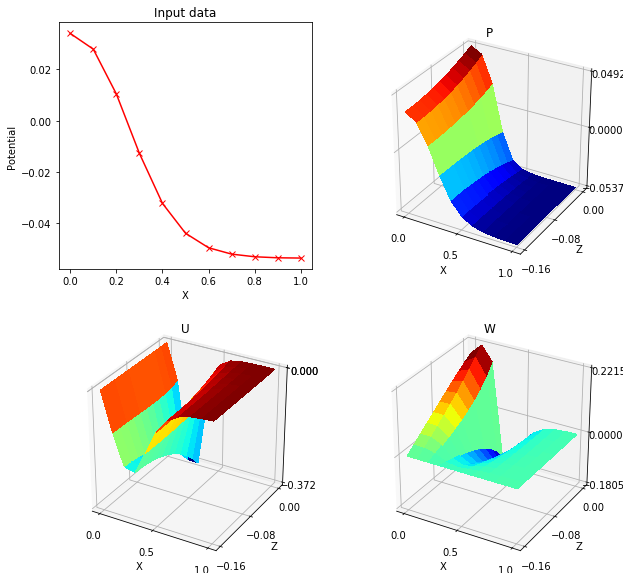

In [39]:
# Plot of unseen data
plot_idx = 10
# Example of input (potential at surface)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(2, 2, 1)
plt.plot(xx,X_uns[plot_idx,:],'r-x')
ax.set_xlabel('X')
ax.set_ylabel('Potential')
ax.set_title('Input data')


# Example of corresponding output: Potential (entire domain)
ax = fig.add_subplot(2, 2, 2, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[plot_idx,P_idx]), 0, np.max(Y_uns[plot_idx,P_idx])])
ax.set_title('P')
ax.plot_surface(X, Z, Y_uns[plot_idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding horisontal velocity (entire domain)
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[plot_idx,U_idx]), 0, np.max(Y_uns[plot_idx,U_idx])])
ax.set_title('U')
ax.plot_surface(X, Z, Y_uns[plot_idx,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of corresponding vertical velocity (entire domain)
ax = fig.add_subplot(2, 2, 4, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Z')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[plot_idx,W_idx]), 0, np.max(Y_uns[plot_idx,W_idx])])
ax.set_title('W')
ax.plot_surface(X, Z, Y_uns[plot_idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

# Save to csv-file
#np.savetxt("/content/drive/My Drive/Results Deep Learning/X_uns_Ex_CNNPUW.csv", X_uns[plot_idx,:], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_P_Ex_CNNPUW.csv", Y_uns[plot_idx,P_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_U_Ex_CNNPUW.csv", Y_uns[plot_idx,U_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_W_Ex_CNNPUW.csv", Y_uns[plot_idx,W_idx], delimiter=",")



### Run test

Interval of inf norms: (0.021901, 0.504707)


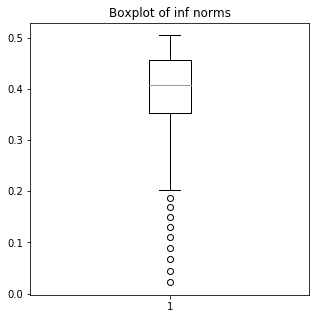




For test data #52 we observe the greatest error


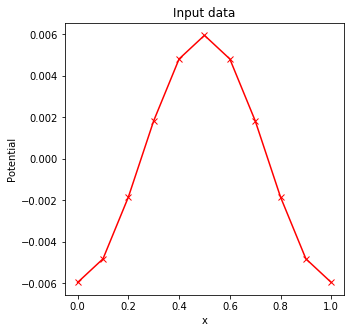

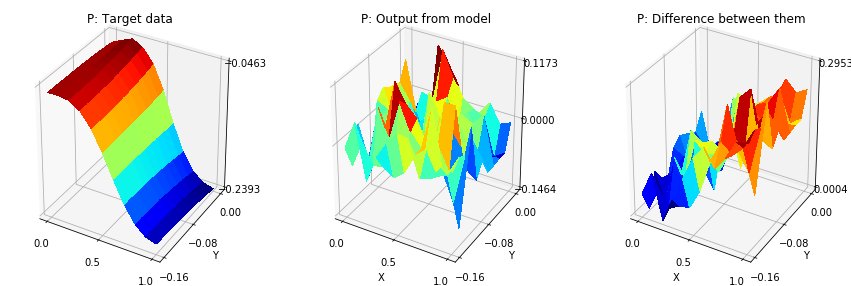

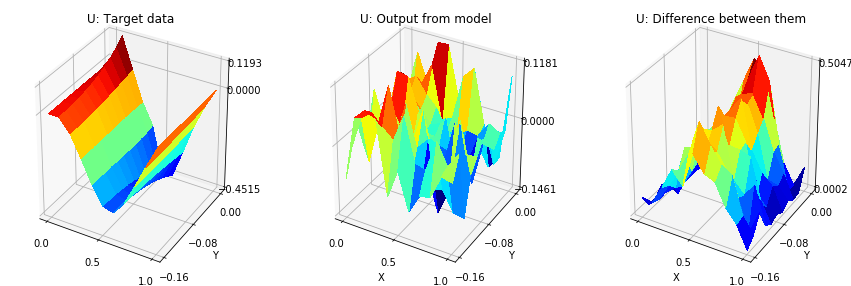

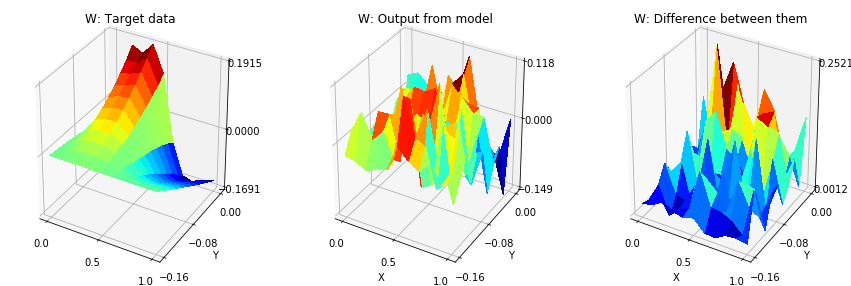

In [42]:
# Test network
test_loss, test_norm = [], []
outputs_from_test, error = [], []
CNN_S.eval()
for it in range(X_uns.shape[0]):
  output_test = CNN_S(Variable(torch.from_numpy(X_uns[it,:,:].reshape((1,1,Nx)))))
  #print(output_test.shape)
  outputs_from_test.append(output_test.detach().numpy())
  target_test = Variable(torch.from_numpy(Y_uns[it,:]).reshape((1,3*Nx*Ny)))
  loss_test = MSE_loss_func(output_test,target_test)
  test_loss.append(loss_test.detach().numpy())
  error.append(torch.abs((output_test-target_test)).detach().numpy())
  norm_test = torch.max(torch.abs(output_test-target_test))
  test_norm.append(norm_test.detach().numpy())

#print(len(test_norm))
idx = np.argmax(test_norm)

# Save to csv-file
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_P_Out_CNNPUW.csv", outputs_from_test[idx][0][P_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_U_Out_CNNPUW.csv", outputs_from_test[idx][0][U_idx], delimiter=",")
#np.savetxt("/content/drive/My Drive/Results Deep Learning/Y_uns_W_Out_CNNPUW.csv", outputs_from_test[idx][0][W_idx], delimiter=",")

print('Interval of inf norms: (%f, %f)' % (np.min(test_norm),np.max(test_norm)))
plt.figure(figsize=(5,5))
plt.boxplot(test_norm)
plt.title('Boxplot of inf norms')
plt.show()

print('\n\n\nFor test data #%i we observe the greatest error' % (idx))

# Example of a test input 
fig = plt.figure(figsize=(5,5))
plt.plot(xx,X_test[idx,:],'r-x')
plt.xlabel('x')
plt.ylabel('Potential')
plt.title('Input data')
plt.show()

### PLOT P #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[idx,P_idx]), 0, np.max(Y_uns[idx,P_idx])])
ax.set_title('P: Target data')
ax.plot_surface(X, Z, Y_uns[idx,P_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][P_idx]), 0, np.max(outputs_from_test[idx][0][P_idx])])
ax.set_title('P: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][P_idx]), 0, np.max(error[idx][0][P_idx])])
ax.set_title('P: Difference between them')
ax.plot_surface(X, Z, error[idx][0][P_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

### PLOT U #####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[idx,U_idx]), 0, np.max(Y_uns[idx,U_idx])])
ax.set_title('U: Target data')
ax.plot_surface(X, Z, Y_uns[idx,U_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][U_idx]), 0, np.max(outputs_from_test[idx][0][U_idx])])
ax.set_title('U: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][U_idx]), 0, np.max(error[idx][0][U_idx])])
ax.set_title('U: Difference between them')
ax.plot_surface(X, Z, error[idx][0][U_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()

#### PLOT W ####
# Example of corresponding target
fig = plt.figure(figsize=(15,5))

ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(Y_uns[idx,W_idx]), 0, np.max(Y_uns[idx,W_idx])])
ax.set_title('W: Target data')
ax.plot_surface(X, Z, Y_uns[idx,W_idx].reshape((Nx,Ny)).T,cmap=cm.jet, linewidth=0, antialiased=False)

# Example of output from model 
ax = fig.add_subplot(1, 3, 2, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(outputs_from_test[idx][0][W_idx]), 0, np.max(outputs_from_test[idx][0][W_idx])])
ax.set_title('W: Output from model')
ax.plot_surface(X, Z, outputs_from_test[idx][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)

# Corresponding error 
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xticks([0, 0.5, 1])
ax.set_yticks([-0.16, -0.08, 0])
ax.set_zticks([np.min(error[idx][0][W_idx]), 0, np.max(error[idx][0][W_idx])])
ax.set_title('W: Difference between them')
ax.plot_surface(X, Z, error[idx][0][W_idx].reshape((Nx,Ny),order='F'),cmap=cm.jet, linewidth=0, antialiased=False)
plt.show()
